# Setup

[Reference](https://sthalles.github.io/simple-self-supervised-learning/)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU, \
                                        Lambda, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical

from tqdm.auto import tqdm
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split

from scipy.spatial.distance import cdist

plt.style.use('ggplot')

# Utils

In [ ]:
def get_negative_mask(batch_size):
    negative_mask = np.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0
    return tf.constant(negative_mask)

def sim_func_dim1(x, y):
    v = tf.matmul(tf.expand_dims(x, 1), tf.expand_dims(y, 2))
    return v


def sim_func_dim2(x, y):
    v = tf.tensordot(tf.expand_dims(x, 1), tf.expand_dims(tf.transpose(y), 0), axes=2)
    return v

# Hyperparameters

In [ ]:
IMAGE_SIZE = 150
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1024
PROJECTION_DIM = 128
TEMPERATURE = 0.1
LEARNING_RATE = 0.001

# Data

In [ ]:
labeled_data = pd.read_csv("data/ext/trainlabels.csv")

labeled_data_path = "data/ext/train"
labeled_data_images = [labeled_data_path + "/" + i + ".jpeg" for i in labeled_data['image']]

labeled_data_labels = labeled_data['level']

print("labeled data images", len(labeled_data_images))
print("labeled data labels", len(labeled_data_labels))

nsample = 5

print(labeled_data_images[nsample], labeled_data_labels[nsample])

labeled_data.iloc[nsample, :]

labeled_data_labels.value_counts()

labeled data images 35122
labeled data labels 35122
data/ext/train/15_right.jpeg 2


level
0    25808
2     5291
1     2442
3      873
4      708
Name: count, dtype: int64

In [ ]:
unreliable_data_images = np.load(f"data/sampled/unreliable/unreliable_image_paths.npy")

print(f"Number of unreliable images: {len(unreliable_data_images)}")

Number of unreliable images: 12145


In [ ]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

    return image

train_ds = tf.data.Dataset.from_tensor_slices(labeled_data_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Training SimCLr

In [ ]:
class CustomAugment(object):
    def __call__(self, sample):
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)

        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x

    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x

    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [ ]:
data_augmentation = Sequential([layers.Lambda(CustomAugment())])

In [ ]:
negative_mask = get_negative_mask(BATCH_SIZE)

In [ ]:
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet101(include_top=False, weights="imagenet",
                                                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model.trainable = False
    inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1, activation='relu')(h)
    projection_2 = Dense(hidden_2, activation='relu')(projection_1)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [ ]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1)
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [ ]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100, stop_loss=3.3):

    epoch_wise_loss = []

    for epoch in range(epochs):
        step_wise_loss = []
        print(f"Epoch {epoch + 1}/{epochs}")
        for image_batch in tqdm(dataset, total=len(dataset), desc="Training"):
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))

        print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

        if np.mean(step_wise_loss) < stop_loss:
            print(f"Stopping training early at epoch {epoch + 1} due to loss <= {stop_loss}")
            return epoch_wise_loss, model

    return epoch_wise_loss, model

In [ ]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

optimizer = Adam(3e-4)

In [ ]:
resnet_simclr_2 = get_resnet_simclr(256, 128, 128)
# resnet_simclr_2 = tf.keras.models.load_model('data/experiments/experiment6/contrastive_learner.h5')

In [ ]:
epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=TEMPERATURE, epochs=20)

Epoch 1/10


Training:   0%|          | 0/548 [00:00<?, ?it/s]

epoch: 1 loss: 4.318
Epoch 2/10


Training:   0%|          | 0/548 [00:00<?, ?it/s]

epoch: 2 loss: 4.336
Epoch 3/10


Training:   0%|          | 0/548 [00:00<?, ?it/s]

epoch: 3 loss: 4.315
Epoch 4/10


Training:   0%|          | 0/548 [00:00<?, ?it/s]

epoch: 4 loss: 4.287
Epoch 5/10


Training:   0%|          | 0/548 [00:00<?, ?it/s]

epoch: 5 loss: 4.331
Epoch 6/10


Training:   0%|          | 0/548 [00:00<?, ?it/s]

epoch: 6 loss: 4.262
Epoch 7/10


Training:   0%|          | 0/548 [00:00<?, ?it/s]

epoch: 7 loss: 4.245
Epoch 8/10


Training:   0%|          | 0/548 [00:00<?, ?it/s]

epoch: 8 loss: 4.264
Epoch 9/10


Training:   0%|          | 0/548 [00:00<?, ?it/s]

epoch: 9 loss: 4.143
Epoch 10/10


Training:   0%|          | 0/548 [00:00<?, ?it/s]

epoch: 10 loss: 4.178


In [ ]:
# prompt: The index of epoch_wise_list where the value stored is 4.061818

index = epoch_wise_loss.index(np.min(epoch_wise_loss))
print(f"Index of epoch_wise_list where the value stored is {np.min(epoch_wise_loss)}: {index}")


Index of epoch_wise_list where the value stored is 4.143101215362549: 8


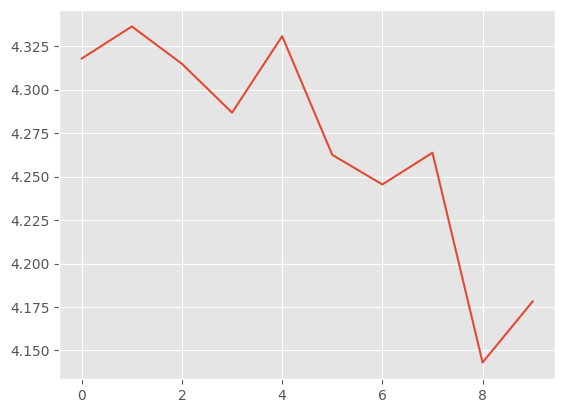

In [ ]:
plt.plot(epoch_wise_loss);

In [ ]:
os.makedirs('models/contrastive_learner/')

resnet_simclr.save('models/contrastive_learner/contrastive_learner.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Down Streaming task

## CNN

In [ ]:
# Load the full model
resnet_simclr = tf.keras.models.load_model('models/contrastive_learner/contrastive_learner.h5')

# Extract the input layer
input_layer = resnet_simclr.layers[0].input

# Extract the layers of the base model and the global average pooling
base_model_output = resnet_simclr.layers[1](input_layer)
global_avg_pool_output = resnet_simclr.layers[2](base_model_output)

CNN_GAP_model = Model(inputs=input_layer, outputs=global_avg_pool_output)

## Extracting CNN features

In [ ]:
def contrastive_feature_extractor(image_paths, name, model):

  contrastive_features_retrieved = []

  for img_path in tqdm(image_paths, total=len(image_paths), desc=f"Retrieving {name} Contrastive features"):
      img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
      x = img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)

      features = model.predict(x, verbose=0)
      features_reduce =  features.squeeze()

      contrastive_features_retrieved.append(features_reduce)

  embeddings = np.array(contrastive_features_retrieved)

  return embeddings

In [ ]:
labeled_data_embeddings = contrastive_feature_extractor(labeled_data_images, name='labeled data',
                                                        model=CNN_GAP_model)
unreliable_data_embeddings = contrastive_feature_extractor(unreliable_data_images, name='Unreliable data',
                                                           model=CNN_GAP_model)

print(labeled_data_embeddings.shape)
print(unreliable_data_embeddings.shape)

Retrieving labeled data Contrastive features:   0%|          | 0/35122 [00:00<?, ?it/s]

Retrieving Unreliable data Contrastive features:   0%|          | 0/12145 [00:00<?, ?it/s]

(35122, 2048)
(12145, 2048)


In [ ]:
np.save('models/contrastive_learner/labeled_data_clr_embeddings.npy',
        labeled_data_embeddings)

np.save('models/contrastive_learner/unreliable_data_clr_embeddings.npy',
        unreliable_data_embeddings)

## Balancing via SMOTE

In [ ]:
labeled_data_features = np.load(
    "models/contrastive_learner/labeled_data_clr_embeddings.npy")

print("Loaded features", labeled_data_features.shape)

Loaded features (35122, 2048)


In [ ]:
# Set the target number of samples for each class
target_samples = 7000

# Upsample the minority classes (classes 1, 2, 3, and 4) using SMOTE
smote = SMOTE(sampling_strategy={1: 10000, 2: 15000, 3: target_samples, 4: target_samples})
oversampled_features, oversampled_labels = smote.fit_resample(labeled_data_features, labeled_data_labels)

# Downsample the majority class (class 0) using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy={0: 20000})
undersampled_features, undersampled_labels = undersampler.fit_resample(oversampled_features, oversampled_labels)

print("Class distribution after balancing:", Counter(undersampled_labels))
print("Shape of oversampled features:", undersampled_labels.shape)
print("Shape of oversampled labels:", undersampled_labels.shape)

Class distribution after balancing: Counter({0: 20000, 2: 15000, 1: 10000, 3: 7000, 4: 7000})
Shape of oversampled features: (59000,)
Shape of oversampled labels: (59000,)


## Data Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    undersampled_features, undersampled_labels,
    stratify=undersampled_labels,
    test_size=0.2, random_state=42
)

In [ ]:
np.save("models/contrastive_learner/X_train.npy", X_train)
np.save("models/contrastive_learner/X_val.npy", X_val)

np.save("models/contrastive_learner/y_train.npy", y_train)
np.save("models/contrastive_learner/y_val.npy", y_val)

## Training

In [ ]:
X_train = np.load("models/contrastive_learner/X_train.npy")
X_val = np.load("models/contrastive_learner/X_val.npy")

y_train = np.load("models/contrastive_learner/y_train.npy")
y_val = np.load("models/contrastive_learner/y_val.npy")

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
classifier = Sequential([
    Dense(1024, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(512),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(256),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(5, activation='softmax')
])

classifier.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# classifier = tf.keras.models.load_model("data/experiments/experiment6/classifier.h5")

In [ ]:
history = classifier.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val))

Epoch 1/250
1475/1475 [==============================] - 17s 6ms/step - loss: 1.2048 - accuracy: 0.4790 - val_loss: 1.0794 - val_accuracy: 0.5350
Epoch 2/250
1475/1475 [==============================] - 9s 6ms/step - loss: 0.9736 - accuracy: 0.5761 - val_loss: 0.9959 - val_accuracy: 0.5728
Epoch 3/250
1475/1475 [==============================] - 8s 5ms/step - loss: 0.8503 - accuracy: 0.6346 - val_loss: 0.8410 - val_accuracy: 0.6399
Epoch 4/250
1475/1475 [==============================] - 9s 6ms/step - loss: 0.7542 - accuracy: 0.6807 - val_loss: 0.7616 - val_accuracy: 0.6801
Epoch 5/250
1475/1475 [==============================] - 8s 5ms/step - loss: 0.6683 - accuracy: 0.7219 - val_loss: 0.7034 - val_accuracy: 0.6984
Epoch 6/250
1475/1475 [==============================] - 9s 6ms/step - loss: 0.6079 - accuracy: 0.7499 - val_loss: 0.6049 - val_accuracy: 0.7553
Epoch 7/250
1475/1475 [==============================] - 9s 6ms/step - loss: 0.5420 - accuracy: 0.7800 - val_loss: 0.5739 - val_a

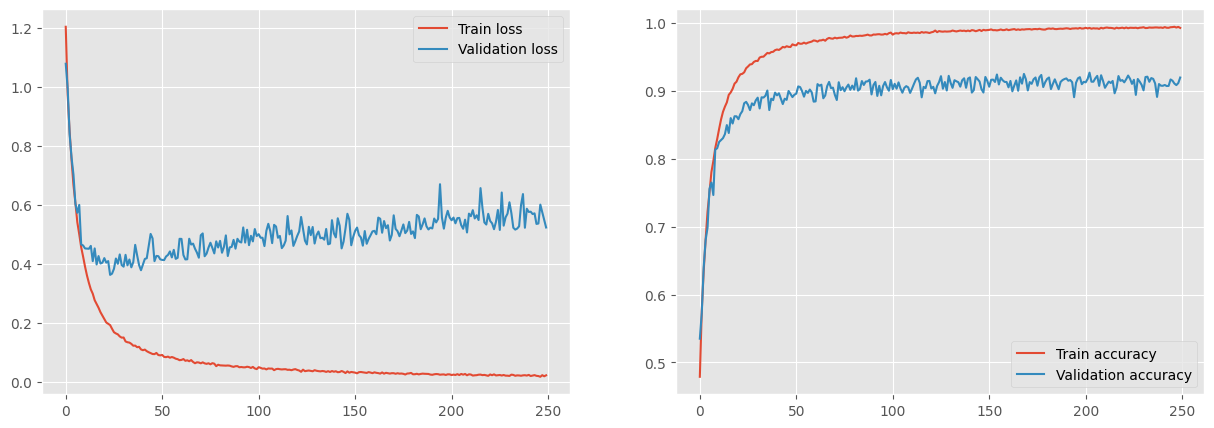

In [ ]:
r = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(r.index, r['loss'], label='Train loss')
ax[0].plot(r.index, r['val_loss'], label='Validation loss')
ax[1].plot(r.index, r['accuracy'], label='Train accuracy')
ax[1].plot(r.index, r['val_accuracy'], label='Validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
train_loss, train_acc = classifier.evaluate(X_train, y_train)
val_loss, val_acc = classifier.evaluate(X_val, y_val)

print('Training Accuracy:', train_acc)
print('Validation Accuracy:', val_acc)

369/369 [==============================] - 1s 3ms/step - loss: 0.5240 - accuracy: 0.9192
Training Accuracy: 0.9999364614486694
Validation Accuracy: 0.919152557849884


In [ ]:
classifier.save("models/contrastive_learner/classifier.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Pseudo labeling

In [ ]:
unreliable_data_features = np.load(
    "models/contrastive_learner/unreliable_data_clr_embeddings.npy")

classifier = tf.keras.models.load_model("models/contrastive_learner/classifier.h5")

classifier_pseudo_labels = classifier.predict(unreliable_data_features)

classifier_pseudo_labels = np.argmax(classifier_pseudo_labels, axis=1)

os.makedirs('data/sampled/unreliable/', exist_ok=True)
np.save(
    "data/sampled/unreliable/unreliable_pseudo_labels.npy",
    classifier_pseudo_labels
)

# Clusters with TSNE

In [ ]:
unreliable_data_features = np.load(
    "models/contrastive_learner/unreliable_data_clr_embeddings.npy"
)

pseudo_labels = np.load(
    "data/sampled/unreliable/unreliable_pseudo_labels.npy"
)

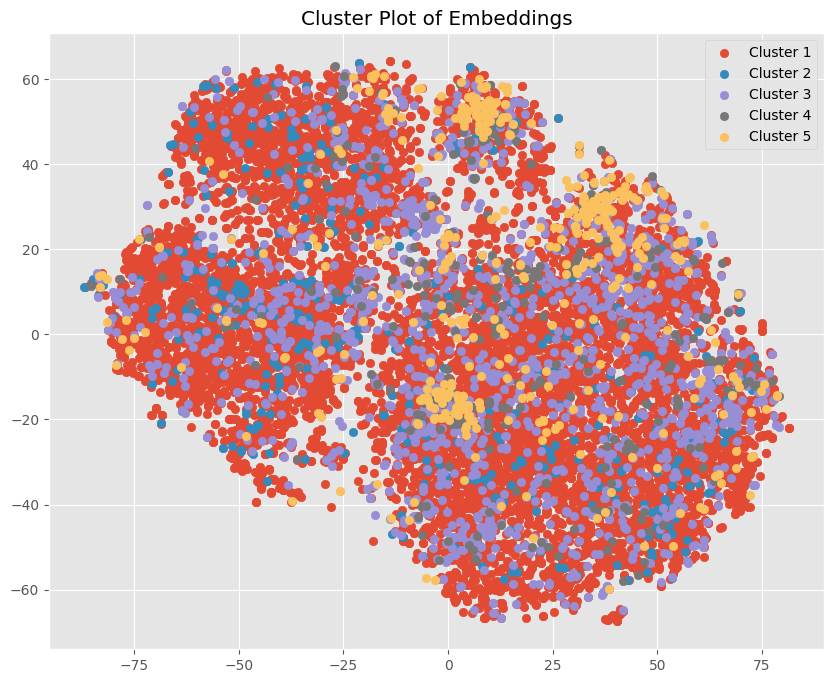

In [ ]:
# Use t-SNE for dimensionality reduction (optional but can be helpful for visualization)
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(unreliable_data_features)

# Create a scatter plot with different colors for each cluster
plt.figure(figsize=(10, 8))
num_clusters = 5  # Set the number of clusters
for i in range(num_clusters):
    cluster_mask = pseudo_labels == i
    plt.scatter(embeddings_tsne[cluster_mask, 0], embeddings_tsne[cluster_mask, 1], label=f'Cluster {i + 1}')

plt.title('Cluster Plot of Embeddings')
plt.legend()
plt.show()